In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import datetime
import json
import itertools
%matplotlib inline
#%matplotlib qt4
#plt.style.use('ggplot')

In [2]:
#create a class
class EspressoRun :
    def __init__(self,filename=None,name=None) :
        if filename != None :
            assert type(filename) == str
            self.filename=filename
            self.name= filename if name == None else name
            self.parseHeader()
            self.df = pd.read_csv(filename, comment='#', header=0,skiprows=self.skipLines)
            #if Parent is null for BODY section it means the function was called in main
            self.df.ix[ pd.isnull(self.df.Parent) & (self.df.Section == "BODY"), 'Parent' ] = 'main'
            #pd.read_csv()
    #         self.df.cpuTime = self.df.cpuTime.astype(np.int64)
        else :
            self.filename = ""
            self.name = ""
            self.header=dict()
        
    def parseHeader(self) :
        #header file is a json
        headerStr=""
        theFile = open(self.filename,'r')
        self.skipLines=1
        for line in theFile :
            if ">>> BENCH BEGIN" in line :
                break
            headerStr += line
            self.skipLines +=1
        theFile.close()
        self.header=json.loads(headerStr)
        self.header=self.header['header']

            
            
    
    def computeParentPercent(self):
        asd = self.df.groupby(['Parent','Section']).aggregate(sum)
        asd = self.df[self.df.Section == "BODY"].groupby('Parent').aggregate(sum)
        asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)

        self.df = pd.merge(self.df , asd , how='left', right_index=True, left_on='Parent')

        self.df['wallTime_parentPercent']=np.nan
        self.df['cpuTime_parentPercent']=np.nan
        self.df['calls_parentPercent']=np.nan

        self.df.cpuTime_parentPercent = self.df.cpuTime / self.df.parentCpuTime * 100
        self.df.wallTime_parentPercent = self.df.wallTime / self.df.parentWallTime * 100
        self.df.calls_parentPercent = self.df.Calls / self.df.parentCalls * 100
    
    def getParentDatas(self,parent) :
        return self.df[ self.df.Parent == parent]
        
    def getPieOfParent(self,parent,metric ='cpuTime_parentPercent'):
        toPlot = self.getParentDatas(parent)[['name',metric]].set_index('name') 
        plt.figure(figsize=(6,6))
        return plt.pie(toPlot,labels = toPlot.index,startangle=90)
    
    def getBodyFigure(self) :
        datas = self.df
        theParents = datas[datas.Section == "BODY"].Parent.unique()
        subplotGridHight = len(theParents)/2 + len(theParents)%2
        fig = plt.figure(figsize=(18,18))
        k = 0
        h = 0
        fig.suptitle("Profiling", fontsize=14, fontweight='bold')
        for parent in theParents:
            #print parent
            #print k,h
            ax = plt.subplot2grid((subplotGridHight,2), (k,h))
            h = (h+1)%2
            if h%2 == 0 : k = k+1

            toBarPlot = datas[(datas.Parent == parent) & (datas.Section == "BODY")][['name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]

            #sort by most cpu demanding
            toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

            cpuOffsets = [0]
            wallOffsets = [0]
            callsOffsets = [0]
            for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
                cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
                wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
                callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
            cpuOffsets = cpuOffsets[:-1]
            wallOffsets = wallOffsets[:-1]
            callsOffsets = callsOffsets[:-1]

            cmap = plt.cm.jet
            zipped = zip(toBarPlot['name'],
                         toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
                         cpuOffsets,wallOffsets,callsOffsets,
                         range(0,len(toBarPlot['name'])))
            #print in reverse order because we wnat the bottom stack to be the least in the legend
            #unfortunately managing the legend order is not so easy
            for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
                plt.bar([1,3,5], #position of the bar
                       [cpu,wall,calls],#height
                       width=1,
                       bottom=[cpuO,wallO,callsO],
                        color = cmap(1- (float(nth)/len(toBarPlot['name']))),
                        label = name 
                      )

            plt.xlim(0,10)
            plt.ylim(0,110)
            plt.title(parent)
            plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
            plt.legend()
        return fig
    
    def getGlobalStackedPlot(self) :
        #if False if 'Condensed' in self.header.keys() else self.header['Condensed'] :
         #   return self.df[['name','cpuTime','cpuTimeStd','wallTime','wallTimeStd']].set_index('name').plot(kind='bar',figsize=(10,6),yerr=['cpuTimeStd','wallTimeStd'])
        #else:
            return self.df[['name','cpuTime','wallTime']].set_index('name').plot(kind='bar',figsize=(10,6))


In [4]:
experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.header

experiment16.df[experiment16.df['name'] == 'init_run']['cpuTime']

0    2410
Name: cpuTime, dtype: float64

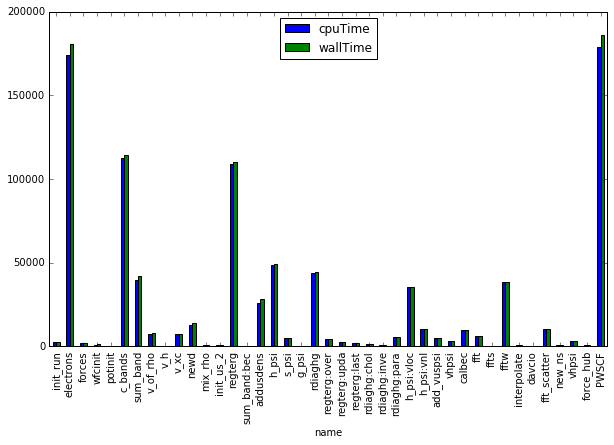

In [30]:
#datas = pd.read_csv('Co3O4-H2-conf1-scf.csv', skiprows=3,header=0)
#datas = pd.read_csv('FIrpic_md_step_10000.csv', skiprows=3,header=0)
experiment8 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_8_8.csv')
experiment8.computeParentPercent()
#experiment.getPieOfParent("electrons","calls_parentPercent")
#asd = experiment.getBodyFigure()
#asd = experiment.getGlobalStackedPlot()

experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.computeParentPercent()


experiment1 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_1_1.csv')
experiment1.computeParentPercent()
experiment4 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_4_4.csv')
experiment4.computeParentPercent()
experiment2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_2_2.csv')
experiment2.computeParentPercent()
experiment32 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_2_16_16.csv')
experiment32.computeParentPercent()
experiment32_2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_2_16_16_2.csv')
experiment32_2.computeParentPercent()
experiment64 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_4_16_16.csv')
experiment64.computeParentPercent()
experiment64_2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_4_16_16_2.csv')
experiment64_2.computeParentPercent()

experiment16.getGlobalStackedPlot()


In [3]:
"""
Organized collection of espresso runs
"""
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(milliseconds=x)                                                                                                                                                                                                                                          
    return str(d)

class Experiment :
    def __init__(self) :
        self.runs = []
    def addRun(self,espressoRun) :
        self.runs.append(espressoRun)
    def plotFunction(self,functions=['PWSCF'],metric='cpuTime',ylabel=None,orderBy='totCores',figure=None, axes=None, ylog=False,ylogBase=10,returned=False):
        #data = [{'index':index,'value':run.df[run.df.name == functionName][metric].values[0]} for run,index in zip(self.runs,range(len(self.runs))) ]
        fig = plt.figure() if figure == None else figure
        ax = fig.add_subplot(111) if axes == None else axes
        
        ylabel = metric if ylabel == None else ylabel
        data=[]
        for run,index in zip(self.runs,range(len(self.runs))) :
            toAppend =  dict(index=index)
            values = []
            for functionName in functions :
                valToAppend = run.df[run.df.name == functionName][metric].values[0] if len(run.df[run.df.name == functionName][metric].values) > 0 else -1
                values.append(valToAppend)
            toAppend['values']=values
            data.append(toAppend)
            
        
        #order by could be or in the header or a column of the df
        if orderBy in self.runs[0].header.keys() :
            for i,pos in zip(data,range(len(data))) :
                data[pos]['orderBy']= self.runs[i['index']].header[orderBy]
                
        dataSorted = sorted(data,key=lambda x : x['orderBy'])
                
        
        marker = itertools.cycle(('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd'))
        
        for functionName,index in zip(functions,range(len(functions))) :
            ys=[ i['values'][index] for i in dataSorted]
            left = range(1,2*len(dataSorted)+1,2)
            toDelete = [ pos for y,pos in zip(ys,range(len(ys))) if y < 0]
            
            ys = [y for y,pos in zip(ys,range(len(ys))) if pos not in toDelete]
            left = [l for l,pos in zip(left,range(len(left))) if pos not in toDelete]
            if (len(left) == 0) : continue

#             print toDelete , ys
            if ylog :
                ax.semilogy(left,ys,label=functionName, marker= marker.next(),basey=ylogBase)
            else :
                ax.plot(left,ys,label=functionName, marker= marker.next())
        
        xticks = range(1,2*len(dataSorted)+1,2)
        xticklabels = [ i['orderBy'] for i in dataSorted]
        plt.xticks(xticks,xticklabels)
        plt.xlabel(orderBy)
        plt.xlim(0,xticks[-1]+1)
        plt.ylabel(metric)
        plt.title(metric)
        
        formatter =  ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
        ax.yaxis.set_major_formatter(formatter) 
        #shrink axis 20% and put the legend outside
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        if returned :
            return fig
        
        
    def plotParents(self,runIndex=0,**kwargs):
        return self.plotFunction(functions=self.getParentsToPlot())
    
    def getParentsToPlot(self):
        return [ 'PWSCF' if i == 'main' else i for i in self.runs[0].df.Parent.unique()  ]
    
    def condense(self) :
        union = pd.concat([ run.df for run in self.runs])
        grouped = union[['name','Section','cpuTime','wallTime','Calls']].groupby(['name','Section'],sort=False)
#         for name,group in grouped :             
#             print name ,np.std(group.cpuTime)
        #Applying different functions to DataFrame columns < CERCA STA ROBA
        newDf=grouped.aggregate(np.mean).reset_index()
        std=grouped.aggregate(np.std).reset_index()


        #print grouped.get_group(('init_run','BODY'))
        #print np.std(grouped.get_group(('init_run','BODY')).wallTime)
        toRet = EspressoRun()
        newDf['Parent'] = self.runs[0].df.Parent
        newDf = newDf[['name','cpuTime','wallTime','Calls','Parent','Section']]
        toRet.df = newDf
        toRet.computeParentPercent()
        toRet.df['cpuTimeStd'] = std['cpuTime']
        toRet.df['wallTimeStd'] = std['wallTime']
        toRet.df['CallsStd'] = std['Calls']
        toRet.headers=[ run.header for run in self.runs]
        toRet.header = dict(self.runs[0].header)
        toRet.header['Condensed'] = True
        
        return toRet
        
    
    
xp = Experiment()
xp.addRun(experiment64)
xp.addRun(experiment32)
xp.addRun(experiment16)
xp.addRun(experiment8)
xp.addRun(experiment4)
xp.addRun(experiment2)
xp.addRun(experiment1)

#xp.plotParents()
#xp2=Experiment()
#xp2.addRun(experiment32)
#xp2.addRun(experiment32_2)
#condensed =xp2.condense()
#condensed.headers
#condensed.getGlobalStackedPlot()




NameError: name 'experiment64' is not defined

In [16]:
experiment1.df

,name,cpuTime,wallTime,Calls,Parent,Section,parentCpuTime,parentWallTime,parentCalls,wallTime_parentPercent,cpuTime_parentPercent,calls_parentPercent
0,init_run,24780,25750,1,main,BODY,1680360,1756840,3,1.465700,1.474684,33.333333
1,electrons,1636950,1711640,1,main,BODY,1680360,1756840,3,97.427199,97.416625,33.333333
2,forces,18630,19450,1,main,BODY,1680360,1756840,3,1.107101,1.108691,33.333333
3,wfcinit,10550,10730,1,init_run,BODY,12540,12880,2,83.307453,84.130781,50.000000
4,potinit,1990,2150,1,init_run,BODY,12540,12880,2,16.692547,15.869219,50.000000
5,c_bands,911620,923390,52,electrons,BODY,1722920,1801290,369,51.262706,52.911337,14.092141
6,sum_band,472900,501600,52,electrons,BODY,1722920,1801290,369,27.846710,27.447589,14.092141
7,v_of_rho,87050,91410,53,electrons,BODY,1722920,1801290,369,5.074696,5.052469,14.363144
8,v_h,2870,3020,53,electrons,BODY,1722920,1801290,369,0.167658,0.166578,14.363144
9,v_xc,85760,90050,54,electrons,BODY,1722920,1801290,369,4.999195,4.977596,14.634146


In [17]:
means

NameError: name 'means' is not defined

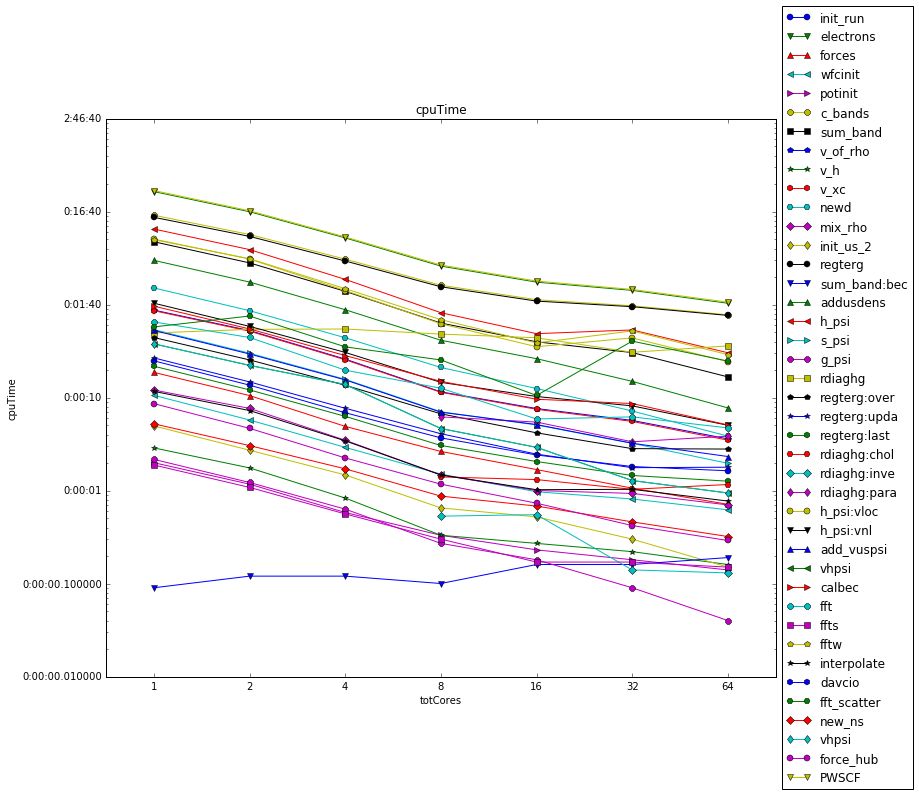

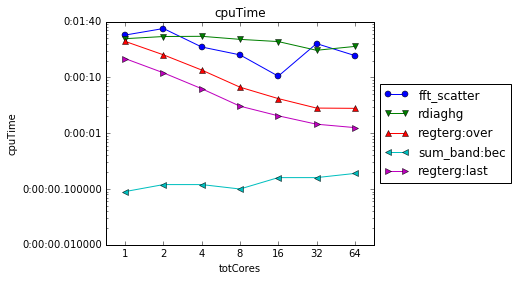

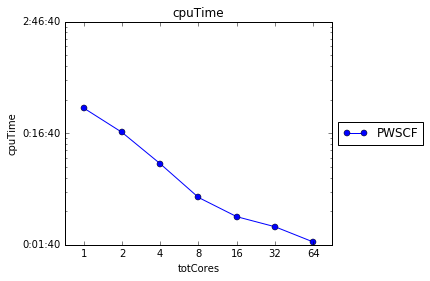

In [23]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)



#plt.ylim(0,100000)
xp.plotFunction(functions=list(experiment16.df.name.values),figure=fig,axes=ax,ylog=True)


fig = plt.figure()#figsize=(15,10))
#plt.ylim(0,100000)
xp.plotFunction(functions=['fft_scatter','rdiaghg','regterg:over','sum_band:bec','regterg:last'],figure=fig,ylog=True)
#xp.plotFunction(functions=experiment1.df.Parent.unique(), figure=fig)
# experiment1.df.Parent.unique().value()

fig = plt.figure()#figsize=(15,10))
xp.plotFunction(functions=['PWSCF'],figure=fig,ylog=True)

    

In [ ]:
xp.plotFunction(functions=xp.getParentsToPlot(),ylog=True,ylogBase=2)

In [ ]:
experiment8.getGlobalStackedPlot()

In [ ]:
#experiment32.getGlobalStackedPlot()
experiment32.df

In [ ]:
experiment32_2.df

In [24]:
experiment64.getGlobalStackedPlot()

KeyError: 'Condensed'

In [ ]:
#all the elements in exp8 but not in exp 4
missing4 = experiment8.df.name[  experiment8.df.name.isin(experiment4.df.name) == False].index.values

exp4_yfill=list(experiment4.df.cpuTime.values)
exp2_yfill=list(experiment2.df.cpuTime.values)
exp1_yfill=list(experiment1.df.cpuTime.values)
#exp4_yfill.insert()
#experiment2.df.name[ experiment2.df.name.isin(experiment1.df.name) == False ]


for i in missing4 :
    exp4_yfill.insert(i,0)
    exp2_yfill.insert(i,0)
    exp1_yfill.insert(i,0)
    
#exp4_yfill

In [ ]:
 experiment2.df.name[  experiment2.df.name.isin(experiment1.df.name) == False].index.values


In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
left = [ i for i in np.arange(2*len(experiment8.df)) if i %2 == 0]
print left
cmap = plt.cm.jet
cs=[ cmap(float(i)/max(left)) for i in left]
#ax.bar(left,experiment2.df.cpuTime,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)

ax.bar(left,exp1_yfill,zs=2,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp2_yfill,zs=1.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,exp4_yfill,zs=1,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment8.df.cpuTime,zs=0.5,zdir='y',label='cpuTime',color=cs,width=2)
ax.bar(left,experiment16.df.cpuTime,zs=0,zdir='y',label='cpuTime',color=cs,width=2)
#plt.bar()
plt.ylim(0,2)
plt.xticks(np.array(left) + 0.5,experiment16.df.name,rotation=90)
plt.yticks([0,0.5,1,1.5,2],reversed([1,2,4,8,16]))

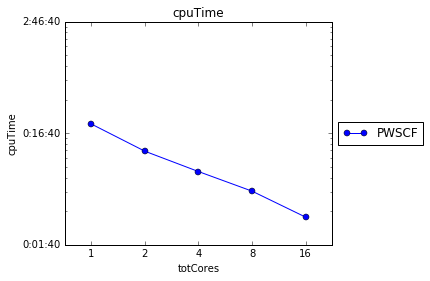

In [20]:
#run over NUMA MACHINES
#1 rank
prefixFolder='/data/datiTesi/NUMA/Co304_bench/SGI/'
OnePerNuma = EspressoRun(prefixFolder+'1rank/1perNUMA/try0/Co3O4-H2-conf1-scf.csv')
OnePerNuma.computeParentPercent()
TwoPerNuma = EspressoRun(prefixFolder+'2rank/2perNuma/try0/Co3O4-H2-conf1-scf.csv')
TwoPerNuma.computeParentPercent()
FourPerNuma = EspressoRun(prefixFolder+'4rank/4perNuma/try0/Co3O4-H2-conf1-scf.csv')
FourPerNuma.computeParentPercent()
EightPerNuma = EspressoRun(prefixFolder+'8rank/8perNuma/try0/Co3O4-H2-conf1-scf.csv')
EightPerNuma.computeParentPercent()
SixteenPerNuma = EspressoRun(prefixFolder+'16rank/16perNuma/try0/Co3O4-H2-conf1-scf.csv')
SixteenPerNuma.computeParentPercent()

numaProgression = Experiment()
numaProgression.addRun(OnePerNuma)
numaProgression.addRun(TwoPerNuma)
numaProgression.addRun(FourPerNuma)
numaProgression.addRun(EightPerNuma)
numaProgression.addRun(SixteenPerNuma)

numaProgression.plotFunction(functions=['PWSCF'],ylog=True)


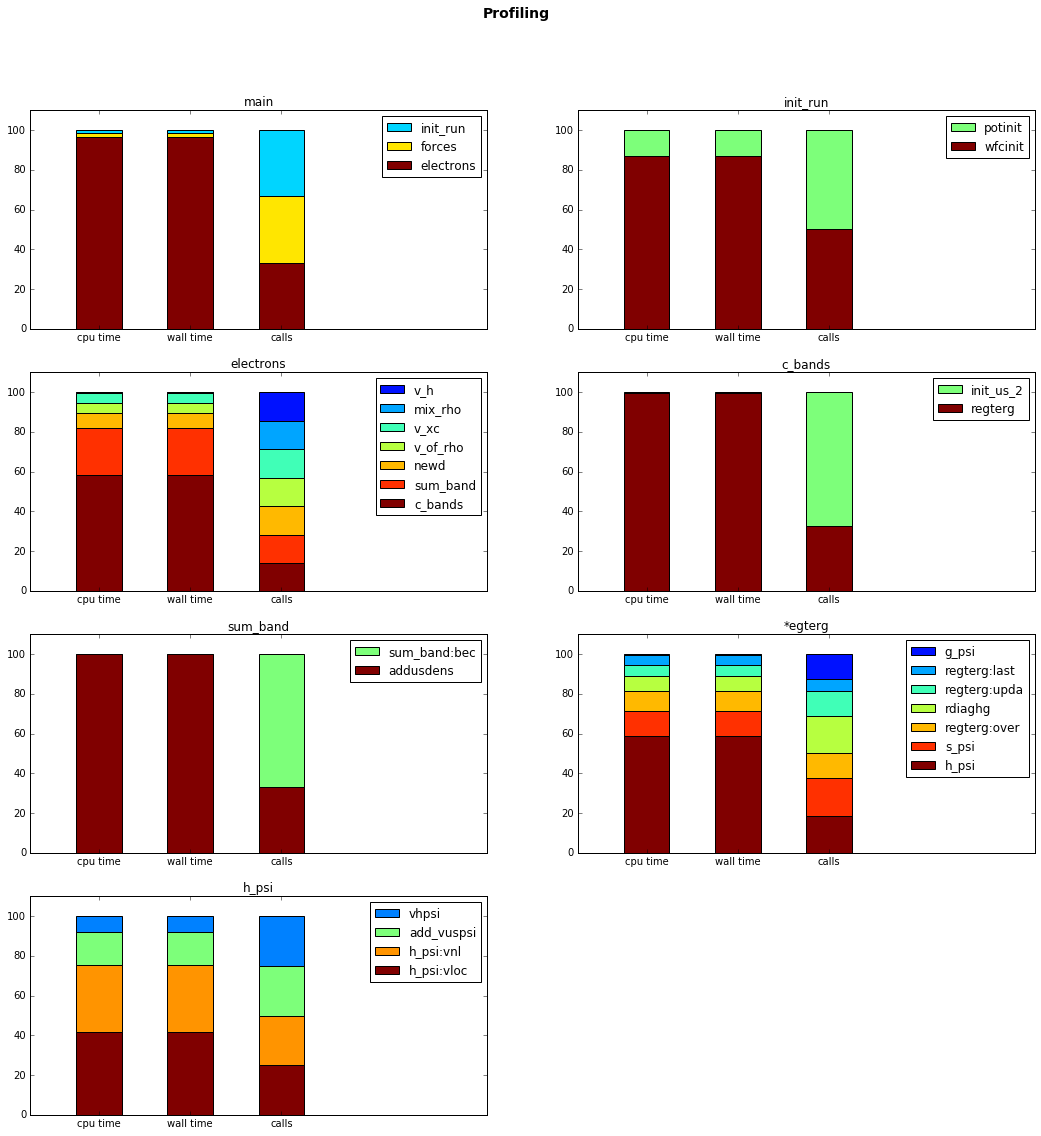

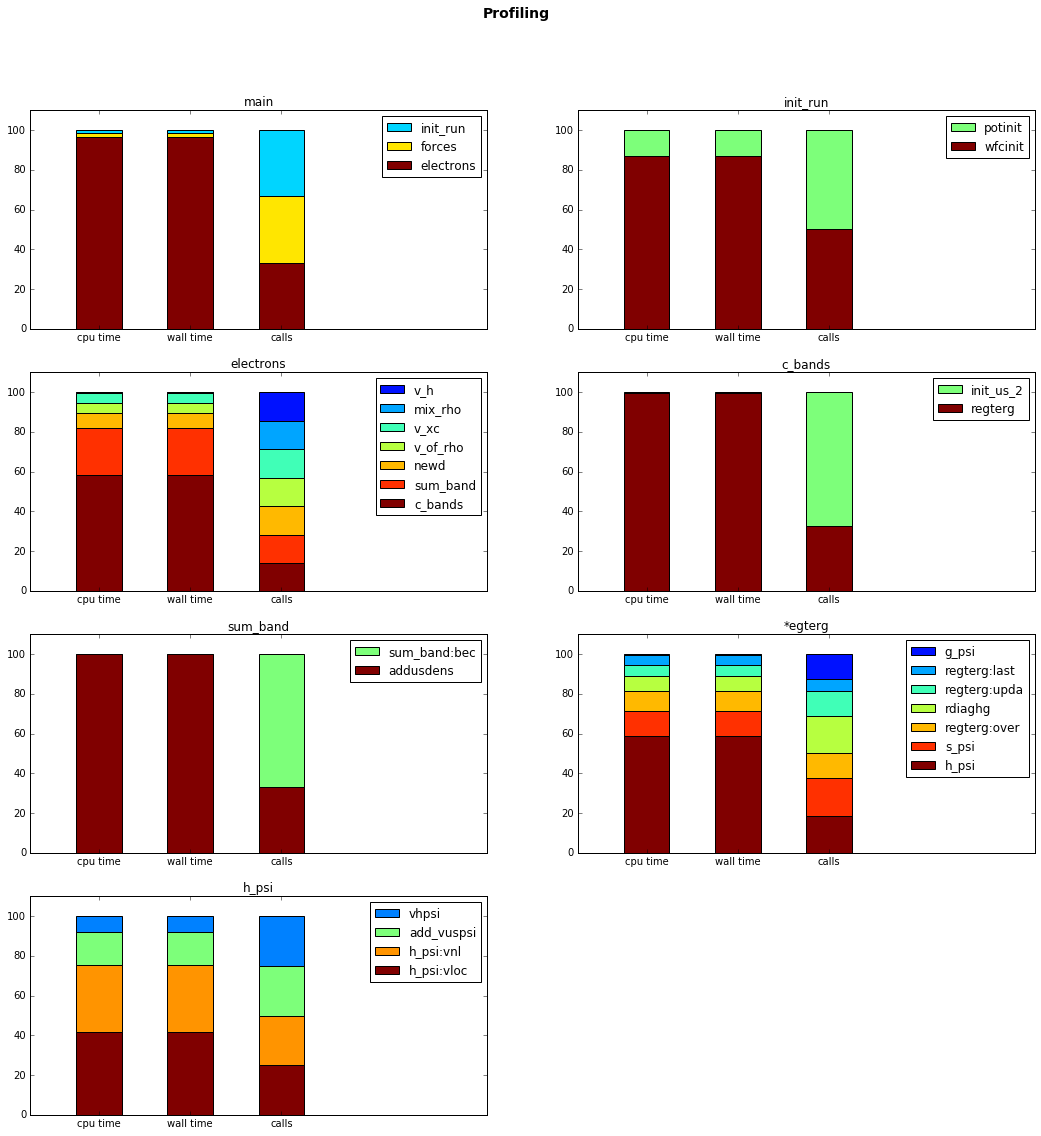